# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib as mpl

### Отключим предупреждения Anaconda

In [3]:
warnings.simplefilter('ignore')

# Загрузим данные

In [4]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/y.pkl.gz', 'rb'))

# N-PLS1
## Приближение к правильному алгоритму
### Опишу ка я центрирование в виде класса, для удобства.

In [5]:
class centrir(BaseEstimator):
    """"Этот класс производит центрирование, а потом из центрированных данных переходит обратно"""
    def  __init__(self, testSize=2*0.02857, column_y=0):
        self.testSize = testSize
        self.column_y=column_y
    
    def centering_and_cv(self,xx,yy):
        x=xx.copy()
        y=yy.copy()
        x_centrir=np.array(x)
        y_centrir=y.iloc[:,self.column_y].to_numpy()
        x_centrir -= x_centrir.mean(axis = 0)
        #x_centrir -= x_centrir.mean()
        self.medium=y_centrir.mean() #Это сренее значение у. 
        y_centrir -= y_centrir.mean() 
        
        X_train, X_test, y_train, y_test = train_test_split(
                x_centrir, y_centrir, test_size=self.testSize 
                )
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        return self
    
    def recentering(self,yy):
            y=yy.copy()
            y+=self.medium
            return y
        

In [6]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2):
        self.n_components = n_components
        
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[:,0]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    
    def predict(self, xx):
        x=xx.copy()
        xn=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        wk=np.array(self.w_k[0,:,:]).reshape(x.shape[1],1)
        wj=np.array(self.w_i[0,:,:]).reshape(x.shape[2],1)
        ww=np.kron(wk,wj).reshape(xn.shape[1])
        R=np.zeros([xn.shape[1],self.n_components])
        t=np.zeros([self.n_components,x.shape[0]])
        R[:,0]=ww.reshape(xn.shape[1])
        t[0,:]=np.dot(xn.copy(),ww).reshape(x.shape[0])
        I=np.eye(xn.shape[1])
        P=np.eye(xn.shape[1])
        p=np.ones([xn.shape[1]])
        B=np.zeros([self.n_components,self.n_components])
        for j in range(0,self.n_components):
            num=0
            for i in self.bf_array[j]:
                B[j,num]=i
                num+=1
        B=np.array([B]).reshape(self.n_components,self.n_components)
        b=B.sum(axis=0)
        kp=np.zeros([xn.shape[1]])
        for f in range(0,self.n_components-1):
            w=np.zeros([xn.shape[1]])
            w=np.kron(np.array(self.w_k[f,:,:]).reshape(x.shape[1],1),
                      np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
                     ).reshape(xn.shape[1])
            w_p=np.zeros([xn.shape[1]])
            w_p=np.kron(np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1),
                        np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
                       ).reshape(xn.shape[1])
            if (f<0.9):
                P=I-np.kron(w,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            else:
                P=I-np.kron(kp,w.transpose()).reshape(xn.shape[1],xn.shape[1])
                kp=np.dot(P,w_p).reshape(xn.shape[1])
            
            
            
            t[f+1,:]=np.dot(xn.copy(),kp.copy()).reshape(x.shape[0])
            R[:,f+1]=kp.reshape(xn.shape[1])
        
        b_pls1=np.dot(R,b).reshape(xn.shape[1])
        y=np.dot(xn,b_pls1).reshape(x.shape[0])
        self.b=b_pls1
        return y

# Делаю новый управляемый решётчатый поиск

### Одним из этапов будет модуль, который будет удалять шумы из нагрузок

In [7]:
# Хочу создать альтернативную реализацию N-PLS1 где нагрузки сразу после разложения будут подвержены 
# удалению шума, и контролируя параметр coef_noise можно будет менять предсказательную способность 
# модели. Возможно придётся прописывать свою реализацию решётчатого поиска, которая будет ориентироваться
# ни на r2, а на нагрузки. Но как это реализовать в автоматическом режиме, я пока не придумал. Есть идея 
# сделать всё итеративно в виде бесконечного цикла, где выход осущесвляется после ввода кодового слова,
# означающего, что нагрузка не понравилась.
import scipy.interpolate
from scipy import interpolate


class delete_noise(): 
    def  __init__(self, coef_noise=1, left_width=3, righ_width=3):
        self.coef_noise = coef_noise
        self.left_width=left_width
        self.righ_width=righ_width
        
#Данная функция метода будет обнулять все элементы вектора нагрузок после действия фукции flatten,
# значение которых меньше среднего значения по вектору,  умноженного на coef_noise. 

    def delete_down_mean(self,vector):
        new_vector=list()
        medium=self.coef_noise*np.mean(np.fabs(vector))
        for i in vector:
            if (np.fabs(i)<medium):
                new_vector.append(0)
            else:
                new_vector.append(i)
        print(new_vector)
        return new_vector
    
#Недостаток предыдущей функции в том, что она выдаёт слишком негладкие нагрузки. Графики выглядят как 
#просто набор единичных пиков (как палки на огороде), а если посмотреть на истинный график, то он должен
#немного объёмнее, если так можно выразиться. Есть идея. Выделяем один максимум, а остальное интерполируем
#по эрмиту. Пока не знаю, сработает ли это. righ_width - количество точек правее максимума, если это возможно
# left_width - количество точек левее максимума, если это возможно. wave_vector нужен для интерполяции. 

    def interpolate_near_one_pick(self, vector, wave_vector):
        new_vector=list()
        maximum=max(np.fabs(vector))
        for i in range(len(vector)):
            if (np.fabs(vector[i])<maximum):
                new_vector.append(0)
            else:
                new_vector.append(vector[i])
                index=i
        interpolate_wave=list()
        data_wave=list()
        data_vector=list()
        
        if ((index+self.righ_width+1)<len(wave_vector) and (index-self.left_width-1)>=0):
            key=0
            for i in range(index-self.left_width,index+self.righ_width+1):
                interpolate_wave.append(wave_vector[i])
            for i in [index-self.left_width-1,index,index+self.righ_width+1]:
                data_wave.append(wave_vector[i])
                data_vector.append(new_vector[i])
        
        if (index==0 or index==len(vector)-1):
            print('Error. Bad index of maximun')
            return 0
            
        if ((index+self.righ_width+1)>=len(wave_vector) and (index-self.left_width-1)>=0):
            key=1
            for i in range(index-self.left_width,len(wave_vector)-1):
                interpolate_wave.append(wave_vector[i])
            for i in [index-self.left_width-1,index,len(wave_vector)-1]:
                data_wave.append(wave_vector[i])
                data_vector.append(new_vector[i])
                
        if ((index+self.righ_width+1)<len(wave_vector) and (index-self.left_width-1)<0):
            key=2
            for i in range(1,index+self.righ_width+1):
                interpolate_wave.append(wave_vector[i])
            for i in [0,index,index+self.righ_width+1]:
                data_wave.append(wave_vector[i])
                data_vector.append(new_vector[i])
                
        if ((index+self.righ_width+1)>=len(wave_vector) and (index-self.left_width-1)<0):
            key=3
            for i in range(1,len(wave_vector)-1):
                interpolate_wave.append(wave_vector[i])
            for i in [0,index,len(wave_vector)-1]:
                data_wave.append(wave_vector[i])
                data_vector.append(new_vector[i])
                
        polynom=scipy.interpolate.PchipInterpolator(data_wave,data_vector)
        new_data=polynom(interpolate_wave).astype(float)
        
        if(key==0):
            index_polynom_part=0
            for i in range(index-self.left_width,index+self.righ_width+1):
                new_vector[i]=new_data[index_polynom_part]
                index_polynom_part+=1
        
        if(key==1):
            index_polynom_part=0
            for i in range(index-self.left_width,len(wave_vector)-1):
                new_vector[i]=new_data[index_polynom_part]
                index_polynom_part+=1
                
        if(key==2):
            index_polynom_part=0
            for i in range(1,index+self.righ_width+1):
                new_vector[i]=new_data[index_polynom_part]
                index_polynom_part+=1
                
        if(key==3):
            index_polynom_part=0
            for i in range(1,len(wave_vector)-1):
                new_vector[i]=new_data[index_polynom_part]
                index_polynom_part+=1
        
        return  new_vector   
        
                

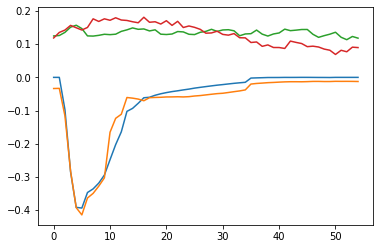

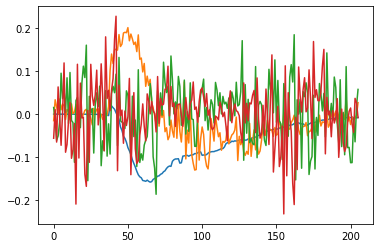

In [32]:
# для гуминовых веществ может иметь смысл взять чуть больше компонент;
# для аминокислот должно быть достаточно одного
model = Tri_PLS1_grid(n_components=4)

# NB: здесь мы ничего не центрируем, что как будто не влияет на результат
X = Xdata_numpy['X']
X -= X.mean(axis = 0) # раскомментировать для центрирования по X

y0 = Ydata.to_numpy()[:,0] # здесь номер колонки выбирает гуминовые вещества / тирозин / триптофан
y0 -= y0.mean() # раскомментировать для центрирования по y
model.fit(X, y0)

# почему-то массивы w_i, w_k оказываются трёхмерными, но последняя размерность всегда 1
# уберём её, чтобы работать, как мы обычно работаем с матрицами
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(model.w_i).transpose())

plt.figure()
plt.plot(flatten(model.w_k).transpose())



In [39]:
d=delete_noise(coef_noise=2, left_width=20, righ_width=7)

In [40]:
n=d.delete_down_mean(flatten(model.w_k).transpose()[:,3])
m=d.interpolate_near_one_pick(flatten(model.w_k).transpose()[:,3],Xdata_numpy['emission'])

[0, 0, 0, 0, 0, 0, 0, 0.1186911071377494, 0, 0, 0, 0, 0, 0, 0, -0.20831318718090006, 0.11557969003826656, 0, 0, 0, 0, -0.13913839996084595, -0.16725384626601753, 0, -0.11168490075571945, 0.11542026829518953, 0, 0, 0, 0, 0, 0, 0.11656441721542232, 0, 0, 0.17910417373644394, 0, 0, 0, 0, 0, 0.17245892771291169, 0.22682509823046618, -0.13099207990626108, 0, 0, 0, 0, 0, 0, 0, 0, -0.14020954579429087, 0, 0, 0, -0.1140224712061965, -0.10794406761796978, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.11110699013521237, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13730017335046024, -0.13405992314930862, 0, 0, 0, -0.12139710512945485, 0, 0, -0.23109329087438152, 0.11201143201136236, -0.14284412145826422, 0, 0, 0, -0.15969796312615803, -0.20941303484796167, 0, -0.12845463659427617, 0.10925178609518169, 0, 0, 0, 0, 0, 0, 0.

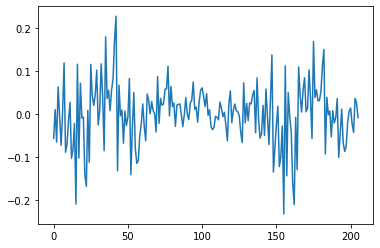

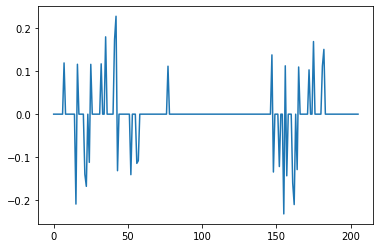

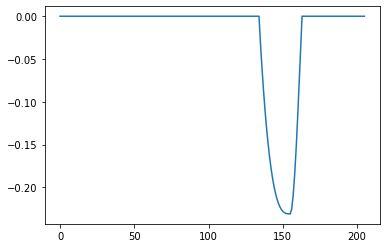

In [41]:
plt.figure()
plt.plot(flatten(model.w_k).transpose()[:,3])

plt.figure()
plt.plot(n)

plt.figure()
plt.plot(m)

In [21]:
a=flatten(model.w_k).transpose()[:,1].shape

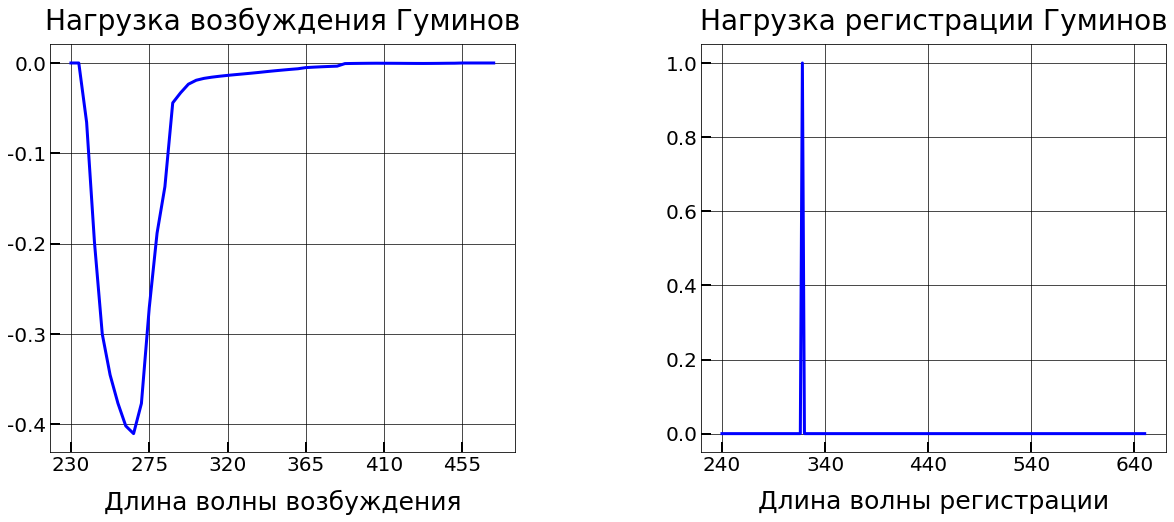

In [71]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(20, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0])
fig_ax_1.plot(flatten(model.w_i).transpose(),"-",color="blue",lw=3)


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Нагрузка возбуждения Гуминов", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

fig_ax_1.set_xticklabels(range(185,545,45), fontsize=20)
fig_ax_1.set_yticklabels(['-0.5','-0.4','-0.3','-0.2','-0.1','0.0','0.1','0.2','0.3'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
#axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(model.w_k).transpose(),"-",color="blue",lw=3)


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Нагрузка регистрации Гуминов", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','0.0','0.2','0.4','0.6','0.8','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
#axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

plt.savefig('Gominy_N-PLS1_loading.png', format='png', dpi=300)
plt.savefig("Gominy_N-PLS1_loading.svg", format="svg")

plt.show();

In [57]:
Xdata_numpy['emission']

array([240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264,
       266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290,
       292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316,
       318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342,
       344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368,
       370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394,
       396, 398, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420,
       422, 424, 426, 428, 430, 432, 434, 436, 438, 440, 442, 444, 446,
       448, 450, 452, 454, 456, 458, 460, 462, 464, 466, 468, 470, 472,
       474, 476, 478, 480, 482, 484, 486, 488, 490, 492, 494, 496, 498,
       500, 502, 504, 506, 508, 510, 512, 514, 516, 518, 520, 522, 524,
       526, 528, 530, 532, 534, 536, 538, 540, 542, 544, 546, 548, 550,
       552, 554, 556, 558, 560, 562, 564, 566, 568, 570, 572, 574, 576,
       578, 580, 582, 584, 586, 588, 590, 592, 594, 596, 598, 60

In [39]:
?plt.plot

In [ ]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(Ydata.iloc[:,0],"-",color="red",ms=20)
axs.plot(Ydata.iloc[:,0].to_numpy()-Ydata.iloc[:,0].to_numpy().mean(),"-",color="blue",ms=20)


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

axs.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Номер образца",  fontsize=25,labelpad=15)
axs.set_title("Центрирование концентраций гуминовых веществ", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(-4,42,5), fontsize=20)
axs.set_yticklabels(range(-30,60,10), fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
#axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('Центрирование концентраций гуминовых веществ.png', format='png', dpi=300)
plt.savefig("Центрирование концентраций гуминовых веществ.svg", format="svg")


plt.show();

# Класс для отбора переменных.
### Пока что он не связан с регрессионным классом, но в будущем я его доработаю.

In [8]:
class variable_class():
    def  __init__(self, number_variable_emission=7, number_variable_excitation=4):
        self.number_variable_emission=number_variable_emission
        self.number_variable_excitation=number_variable_excitation
        
    def finding_variable(self,bn_npls1):
        dict_with_collumns=dict()
        b_npls1=bn_npls1.copy()
        for i in range(b_npls1.shape[1]):
            col_max=max(np.fabs(b_npls1[:,i]))
            dict_with_collumns[col_max]=i
        column_list_tuple=sorted(dict_with_collumns.items(), reverse=True)[:self.number_variable_excitation]
        num_column_r=list()
        for maxim, number in column_list_tuple:
            num_column_r.append(number)
        num_column=sorted(num_column_r)
        b_new_columns=b_npls1[:,num_column]
        self.num_column=num_column # Номера отобранных колонок матриц начиная с 0, так как индексация range () начинается с 0 
        # теперь отберу строчки
        dict_with_rows=dict()
        for i in range(b_new_columns.shape[0]):
            row_max=max(np.fabs(b_new_columns[i,:]))
            dict_with_rows[row_max]=i
        row_list_tuple=sorted(dict_with_rows.items(), reverse=True)[:self.number_variable_emission]
        num_row_r=list()
        for maxim,number in row_list_tuple:
            num_row_r.append(number)
        num_row=sorted(num_row_r)
        self.num_row=num_row  # Номера отобранных строчек
        b_new=b_new_columns[num_row,:]
        self.b_new=b_new
        return self
    
    def transform(self,xn):
        #На вход подавать тензор
        x=xn.copy()
        x_new=np.zeros([x.shape[0],len(self.num_row),len(self.num_column)])
        for matrixx in range(x.shape[0]):
            len_x_new=0
            for i in self.num_column:
                shape_x_new=0
                for j in self.num_row:
                    x_new[matrixx,shape_x_new,len_x_new]=x[matrixx,j,i]
                    shape_x_new+=1
                len_x_new+=1
        return x_new
    
    def emission_vave_lenth(self,emissions_array):
        emission=emissions_array.copy()
        emission_new=np.zeros([len(self.num_row)])
        for i in range(len(self.num_row)):
            emission_new[i]=emission[self.num_row[i]]
        return emission_new
    
    def excitation_vave_lenth(self, excitation_array):
        excitation=excitation_array.copy()
        excitation_new=np.zeros([len(self.num_column)])
        for i in range(len(self.num_column)):
            excitation_new[i]=excitation[self.num_column[i]]
        return excitation_new

# Центрируем данные (замена: вместо 3-х методов теперь 2)

In [9]:
cen=centrir(testSize=0.1428,column_y=0)

In [10]:
result=cen.centering_and_cv(Xdata_numpy['X'],Ydata)

In [11]:
y_train=result.y_train
y_test=result.y_test
X_train=result.X_train
X_test=result.X_test

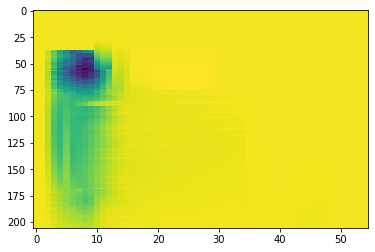

In [12]:
plt.imshow(X_train[5,:,:],aspect='auto')
plt.show()

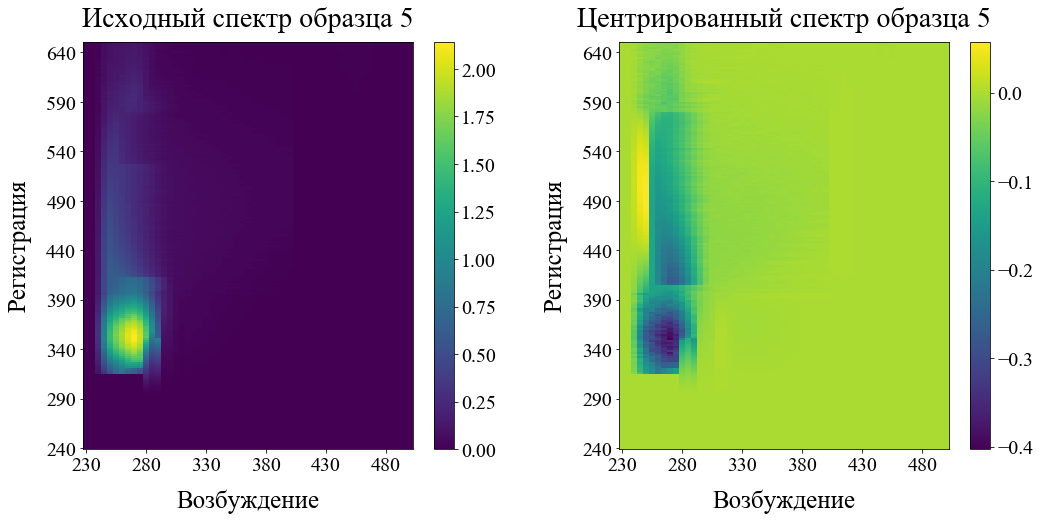

In [75]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(17, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0, 0])
plt.imshow(Xdata_numpy['X'][4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Исходный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[0, 1])
plt.imshow(X_train[4,:,:],aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Центрированный спектр образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('centering.png', format='png', dpi=300)
plt.savefig("centering.svg", format="svg")

plt.show();

In [65]:
?plt.title

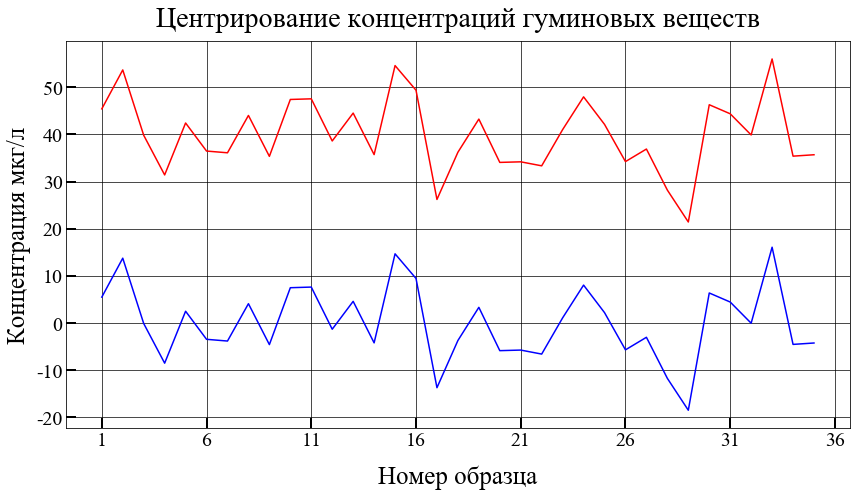

In [83]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(Ydata.iloc[:,0],"-",color="red",ms=20)
axs.plot(Ydata.iloc[:,0].to_numpy()-Ydata.iloc[:,0].to_numpy().mean(),"-",color="blue",ms=20)


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

axs.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Номер образца",  fontsize=25,labelpad=15)
axs.set_title("Центрирование концентраций гуминовых веществ", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(-4,42,5), fontsize=20)
axs.set_yticklabels(range(-30,60,10), fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
#axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('Центрирование концентраций гуминовых веществ.png', format='png', dpi=300)
plt.savefig("Центрирование концентраций гуминовых веществ.svg", format="svg")


plt.show();

In [769]:
y_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_test']
y_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['y_train']
X_train=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_train']
X_test=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final.pkl.gz', 'rb'))['X_test']

# Делаем применение сразу по всем компонентам

In [13]:
npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}

In [14]:
%%time
gridCought=GridSearchCV(npls1, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(X_train.copy(),y_train.copy())
r2_p=gridCought.score(X_test.copy(), y_test.copy())
r2_cv=gridCought.cv_results_[ "mean_test_score" ]
r2_c=gridCought.cv_results_[ "mean_train_score" ]
predictors=gridCought.predict(X_test.copy())

Wall time: 27min 37s


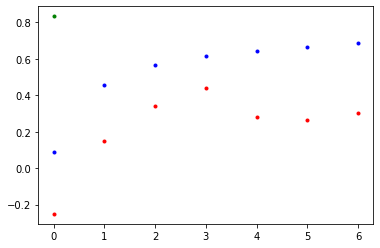

In [15]:
plt.plot(r2_p,".",color='green')
plt.plot(r2_c,".",color='blue')
plt.plot(r2_cv,".",color='red')
plt.show()

In [16]:
b_npls1_full=gridCought.best_estimator_.b.reshape(206,55)

In [58]:
gridCought.best_estimator_.b

array([-0.0096021 , -0.00968835, -0.01134509, ...,  0.00720828,
        0.00701525,  0.00667884])

In [38]:
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

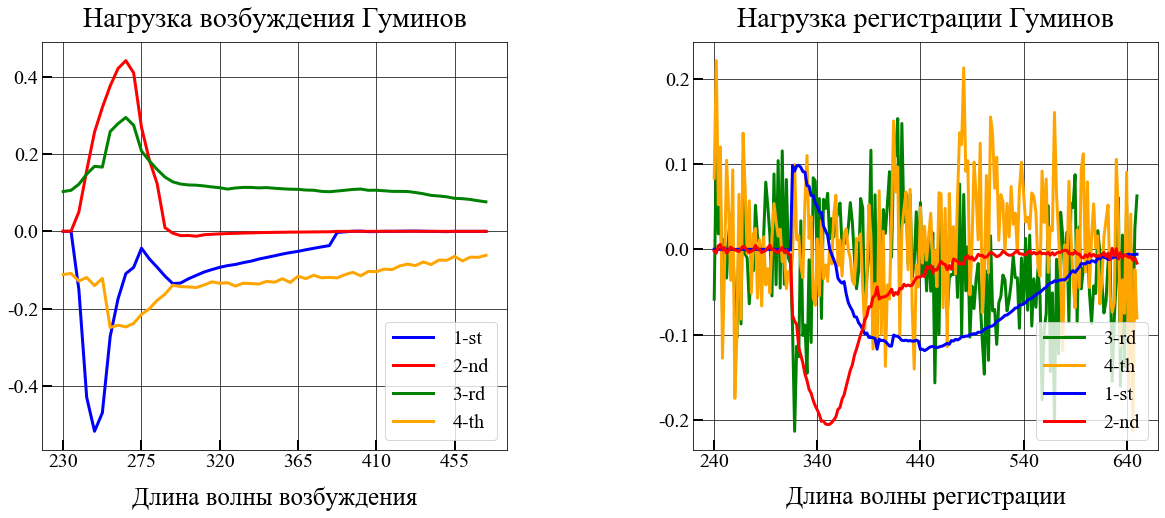

In [56]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(20, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.4, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0])
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,0],"-",color="blue",lw=3,label="1-st")
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,1],"-",color="red",lw=3,label="2-nd")
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
fig_ax_1.plot(flatten(gridCought.best_estimator_.w_i).transpose()[:,3],"-",color="orange",lw=3,label="4-th")


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

#fig_ax_1.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_1.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_1.set_xlabel("Длина волны возбуждения",  fontsize=25,labelpad=15)
fig_ax_1.set_title("Нагрузка возбуждения Гуминов", fontsize=28,loc="center" ,pad=15)
fig_ax_1.tick_params(which='major', length=10, width=2)
#fig_ax_1.legend()
#axs.ticklabel_format()

fig_ax_1.set_xticklabels(range(185,545,45), fontsize=20)
fig_ax_1.set_yticklabels(['-0.5','-0.4','-0.2','0.0','0.2','0.4','0.1','0.2','0.3','0.4'], fontsize=20)
fig_ax_1.get_xaxis().set_tick_params(direction='in')
fig_ax_1.get_yaxis().set_tick_params(direction='in')
fig_ax_1.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

fig_ax_2 = fg.add_subplot(gs[0, 1])
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,2],"-",color="green",lw=3,label="3-rd")
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,3],"-",color="orange",lw=3,label="4-th")
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,0],"-",color="blue",lw=3,label="1-st")
fig_ax_2.plot(flatten(gridCought.best_estimator_.w_k).transpose()[:,1],"-",color="red",lw=3,label="2-nd")


#axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

#fig_ax_2.set_ylabel('Концентрация мкг/л',  fontsize=25,labelpad=5)
fig_ax_2.grid(color="black", drawstyle="default", linewidth=0.7)
fig_ax_2.set_xlabel("Длина волны регистрации",  fontsize=25,labelpad=15)
fig_ax_2.set_title("Нагрузка регистрации Гуминов", fontsize=28,loc="center" ,pad=15)
fig_ax_2.tick_params(which='major', length=10, width=2)
#fig_ax_2.legend()
#axs.ticklabel_format()

fig_ax_2.set_xticklabels(range(140,740,100), fontsize=20)
fig_ax_2.set_yticklabels(['5','-0.2','-0.1','0.0','0.1','0.2','1.0','9'], fontsize=20)
fig_ax_2.get_xaxis().set_tick_params(direction='in')
fig_ax_2.get_yaxis().set_tick_params(direction='in')
fig_ax_2.legend(loc=4,fontsize=20, markerscale=1,handletextpad=1)

#axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран

#plt.savefig('Humic_N-PLS1_loading.png', format='png', dpi=300)
#plt.savefig("Humic_N-PLS1_loading.svg", format="svg")

plt.show();

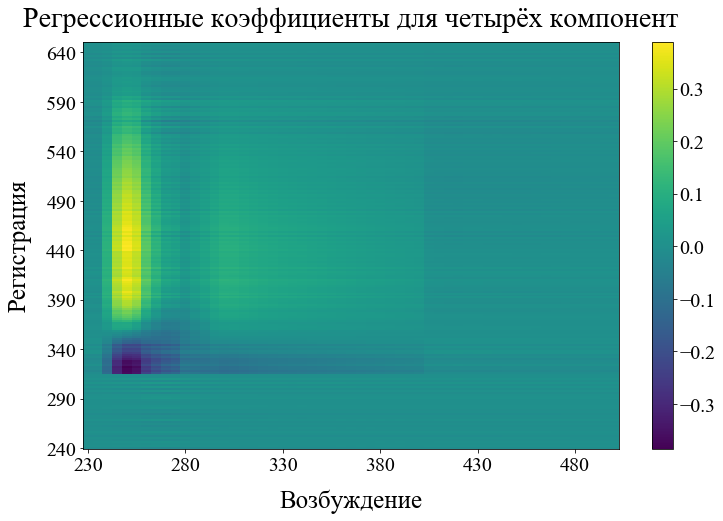

In [65]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(12, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0, hspace=0)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Регрессионные коэффициенты для четырёх компонент",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)
plt.savefig('Humic_b_npls1_full.png', format='png', dpi=300)
plt.savefig("Humic_b_npls1_full.svg", format="svg")

plt.show();

### Определю ка я число волн emission в цикле, а то 7 плохо на Гуминах работает

In [803]:
new_r2_p=list()
new_r2_cv=list()
new_r2_c=list()
nmt=list()

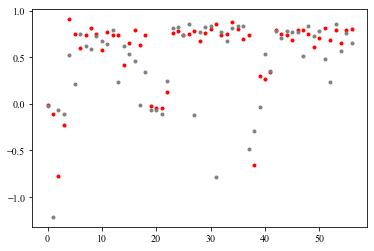

In [815]:
new_r2_p=list()
new_r2_cv=list()
new_r2_c=list()
nmt=list()
for j in range(2,5):
    for i in range(2,21):
        select=variable_class(number_variable_emission=i, number_variable_excitation=j)
        select.finding_variable(b_npls1_full)
        x_new=select.transform(Xdata_numpy['X'])
        new_cen=centrir(testSize=0.1428,column_y=2)
        new_result=new_cen.centering_and_cv(x_new,Ydata)
        y_train=new_result.y_train
        y_test=new_result.y_test
        X_train=new_result.X_train
        X_test=new_result.X_test
        new_npls1=Tri_PLS1_grid()
        parametrsNames={'n_components': range(1,8)}
        new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
        new_gridCought.fit(X_train.copy(),y_train.copy())
        new_r2_p+=[new_gridCought.score(X_test.copy(), y_test.copy())]
        new_r2_cv+=[max(new_gridCought.cv_results_[ "mean_test_score" ])]
        new_r2_c+=[max(new_gridCought.cv_results_[ "mean_train_score" ])]
        nmt+=[0.5*(new_gridCought.score(X_test.copy(), y_test.copy())+max(new_gridCought.cv_results_[ "mean_test_score" ]))]
plt.plot(new_r2_cv,".", color="red")
plt.plot(nmt,".", color="grey")
plt.show()

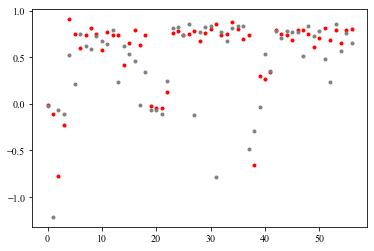

In [816]:
#plt.plot(new_r2_p,".", color="green")
#plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.plot(nmt,".", color="grey")
plt.show()

In [817]:
max(nmt)

0.8555678761837362

In [818]:
max(new_r2_cv)

0.9080603594930906

In [819]:
mma=nmt

In [820]:
n_r2_cv_prr=new_r2_cv

In [142]:
len(n_r2_cv_prr)/3

19.0

In [58]:
print(new_r2_cv[13],new_r2_p[13])

-0.1840198700832275 -0.2156442228061255


In [49]:
14 0.42726841144390604

14

In [50]:
r2_cv_pr=new_r2_cv
r2_p_pr=new_r2_p

In [59]:
print(r2_cv_pr[13],r2_p_pr[13])

0.42726841144390604 0.07090149193088291


#### Построю ка график в зависимости от число длин волн r2

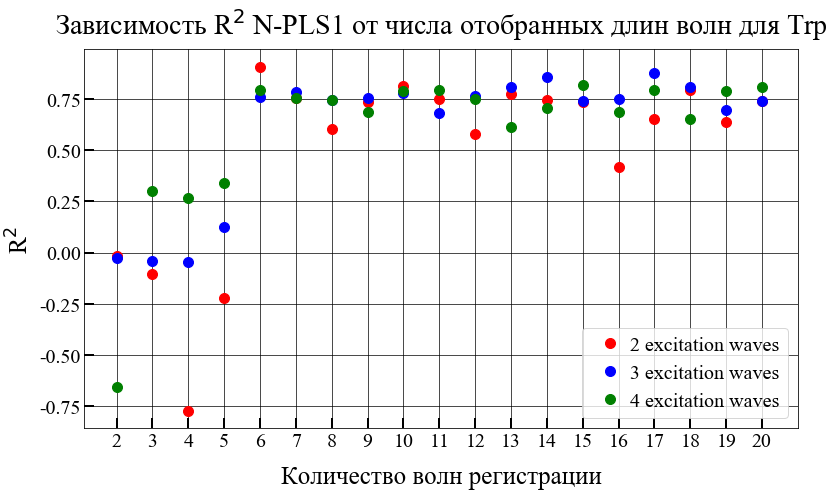

In [823]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(n_r2_cv_prr[:19],".",color="red",ms=20,label='2 excitation waves')
axs.plot(n_r2_cv_prr[19:38],".",color="blue",ms=20,label='3 excitation waves')
axs.plot(n_r2_cv_prr[38:57],".",color="green",ms=20,label='4 excitation waves')

axs.set_xticks(range(0,19,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(-0.60, 0.60, num = 13))

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество волн регистрации",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ N-PLS1 от числа отобранных длин волн для Trp", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(2,21,1), fontsize=20)
axs.set_yticklabels(['0','-0.75','-0.50','-0.25','0.00','0.25',
                     '0.50','0.75','0.20','0.30','0.40','0.50','0.60','0.70'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=4,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=19) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1 Tyr с использованием числа отобранных длин волн для Trp.png', format='png', dpi=300)
plt.savefig("N-PLS1 Tyr с использованием числа отобранных длин волн для Trp.svg", format="svg")


plt.show();

##### Для Гуминов мне приглянулись 2 точки: 2 excit. 9 emission and 4 excit. 16 emiss.

In [645]:
mma[7]

-1.44546081556455

In [646]:
mma[13]

-0.21164932246441437

In [824]:
pkl.dump(
	{'r2_cv': n_r2_cv_prr, 'r2_p': mma},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_number_wave_emission_excitation.pkl.gz', 'wb')
)

### Теперь произведём отбор переменных из исходных данных, чтобы потом заново центрировать и обучить новую модель

In [929]:
select=variable_class(number_variable_emission=7, number_variable_excitation=3)
select.finding_variable(b_npls1_full)

In [930]:
x_new=select.transform(Xdata_numpy['X'])

### Заново центрируем новые данные

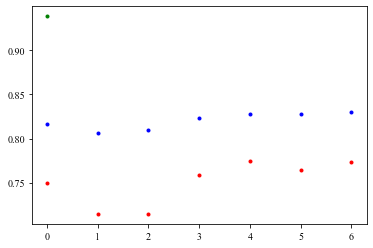

In [931]:
new_r2_cv=[0,0]
new_cen=centrir(testSize=0.1428,column_y=2)
new_result=new_cen.centering_and_cv(x_new,Ydata)
y_train=new_result.y_train
y_test=new_result.y_test
X_train=new_result.X_train
X_test=new_result.X_test
new_npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}
new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
new_gridCought.fit(X_train.copy(),y_train.copy())
new_r2_p=new_gridCought.score(X_test.copy(), y_test.copy())
new_r2_cv=new_gridCought.cv_results_[ "mean_test_score" ]
new_r2_c=new_gridCought.cv_results_[ "mean_train_score" ]
new_predictors=new_gridCought.predict(X_test.copy())
plt.plot(new_r2_p,".", color="green")
plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.show()

In [932]:
new_r2_p

0.9386911702249452

In [290]:
new_result=new_cen.centering_and_cv(x_new,Ydata)

In [291]:
y_train=new_result.y_train
y_test=new_result.y_test
X_train=new_result.X_train
X_test=new_result.X_test

### Снова делаем обучение по всем компонентам, но уже на новых данных

In [292]:
new_npls1=Tri_PLS1_grid()
parametrsNames={'n_components': range(1,8)}

In [293]:
%%time
new_gridCought=GridSearchCV(new_npls1, parametrsNames, cv=5,return_train_score=True)
new_gridCought.fit(X_train.copy(),y_train.copy())
new_r2_p=new_gridCought.score(X_test.copy(), y_test.copy())
new_r2_cv=new_gridCought.cv_results_[ "mean_test_score" ]
new_r2_c=new_gridCought.cv_results_[ "mean_train_score" ]
new_predictors=new_gridCought.predict(X_test.copy())

Wall time: 214 ms


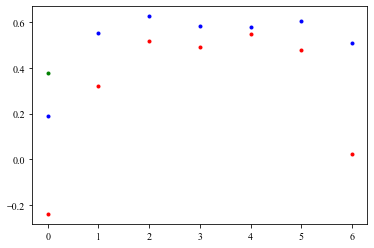

In [529]:
plt.plot(new_r2_p,".", color="green")
plt.plot(new_r2_c, ".", color="blue")
plt.plot(new_r2_cv,".", color="red")
plt.show()

In [933]:
b_npls1_small=new_gridCought.best_estimator_.b.reshape(7,3)

In [934]:
b_npls1_small

array([[ 1.18793675,  1.43212358,  0.56367563],
       [-0.22889696, -0.37208574, -0.71624092],
       [-0.1771388 , -0.32420899, -0.16310932],
       [-0.22723987, -0.0176538 , -0.49612528],
       [-0.38626498,  0.41808796,  0.30527622],
       [-0.54427213,  0.19810908, -0.02808255],
       [-0.43224991,  0.48546586, -0.08742599]])

In [935]:
new_gridCought.best_estimator_

Tri_PLS1_grid(n_components=5)

In [936]:
select.emission_vave_lenth(Xdata_numpy['emission'])

array([376., 466., 474., 492., 504., 570., 632.])

In [937]:
select.excitation_vave_lenth(Xdata_numpy['excitation'])

array([260., 265., 270.])

In [535]:
[318., 354., 362., 370., 378., 452., 458., 474., 488.]

[318.0, 354.0, 362.0, 370.0, 378.0, 452.0, 458.0, 474.0, 488.0]

In [536]:
[250., 255.]

[250.0, 255.0]

In [948]:
pkl.dump(
	{'r2_cv': new_r2_cv, 'r2_c': new_r2_c, 'r2_p': new_r2_p, 'predict':new_predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train, 'b_npls1_v-s':b_npls1_small, 
     'emission_vale_lendth':select.emission_vave_lenth(Xdata_numpy['emission']),
     'excitation_vale_lendth':select.excitation_vave_lenth(Xdata_numpy['excitation']),
     'b_npls1_without_v-s':b_npls1_full},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_7_3.pkl.gz', 'wb')
)

In [5]:
r=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_14_2.pkl.gz', 'rb'))['b_npls1_without_v-s']

In [6]:
max(r)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [7]:
r

array([[ 5.94974443e-05, -9.39291459e-06, -5.33079404e-03, ...,
        -2.29473635e-05,  5.86624633e-05, -2.32035859e-05],
       [ 1.12405272e-04, -1.77441548e-05, -6.72535274e-03, ...,
        -4.30682286e-05,  1.10819486e-04, -4.38339840e-05],
       [-5.53331567e-04,  8.73489288e-05,  3.48308487e-02, ...,
         2.12156585e-04, -5.45529581e-04,  2.15780958e-04],
       ...,
       [-1.47364841e-04,  2.33262946e-05,  1.64301105e-01, ...,
         6.97059895e-05, -1.45671637e-04,  5.76195435e-05],
       [ 4.77280034e-03, -7.53490193e-04, -4.37298719e-01, ...,
        -1.84162847e-03,  4.70584335e-03, -1.86136814e-03],
       [ 2.25272949e-03, -3.55671943e-04, -2.79082255e-01, ...,
        -8.75426537e-04,  2.22130657e-03, -8.78624507e-04]])

In [155]:
r

array([318., 350., 352., 358., 362., 364., 366., 378., 462.])

In [20]:
b_npls1_full_humic=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Gominy_N-PLS1_final_with_variable_selection_9_2.pkl.gz', 'rb'))['b_npls1_without_v-s']
b_npls1_full_Tyr=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Tyr_N-PLS1_final_with_variable_selection_9_2.pkl.gz', 'rb'))['b_npls1_without_v-s']
b_npls1_full_Trp=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['b_npls1_without_v-s']

In [21]:
select=variable_class(number_variable_emission=6, number_variable_excitation=2)
select.finding_variable(b_npls1_full_Trp)

In [22]:
x_new=select.transform(Xdata_numpy['X'])

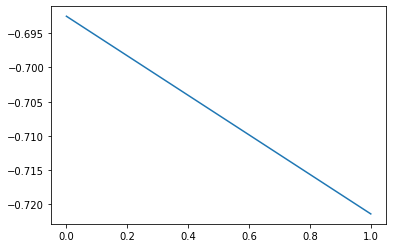

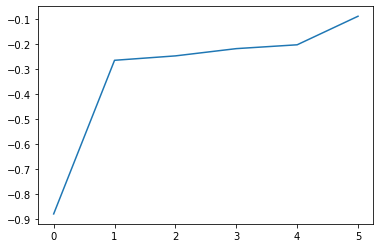

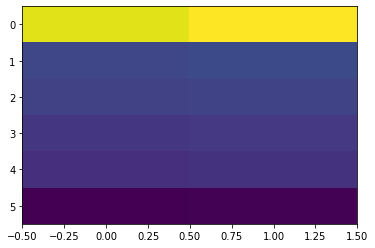

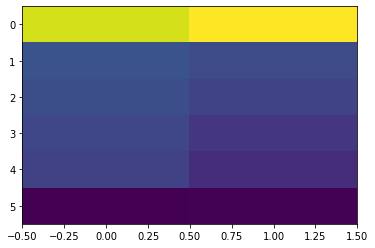

In [29]:
# для гуминовых веществ может иметь смысл взять чуть больше компонент;
# для аминокислот должно быть достаточно одного
model = Tri_PLS1_grid(n_components=1)

# NB: здесь мы ничего не центрируем, что как будто не влияет на результат
X = x_new
#X -= X.mean(axis = 0) # раскомментировать для центрирования по X

y0 = Ydata.to_numpy()[:,2] # здесь номер колонки выбирает гуминовые вещества / тирозин / триптофан
#y0 -= y0.mean() # раскомментировать для центрирования по y
model.fit(X, y0)

# почему-то массивы w_i, w_k оказываются трёхмерными, но последняя размерность всегда 1
# уберём её, чтобы работать, как мы обычно работаем с матрицами
def flatten(x):
    sh = x.shape
    return x.reshape(sh[0:len(sh)-1])

plt.figure()
plt.plot(flatten(model.w_i).transpose())

plt.figure()
plt.plot(flatten(model.w_k).transpose())

plt.figure()
plt.imshow(np.kron(model.w_k[0,:],model.w_i[0,:]).reshape([6,2]),aspect='auto')

plt.figure()
plt.imshow(x_new[1,:,:],aspect='auto')

In [235]:
a=[[1, 0, 0, 0, 2],[0, 0, 3, 0, 0],[1,2,3,4,5]]

In [236]:
a

[[1, 0, 0, 0, 2], [0, 0, 3, 0, 0], [1, 2, 3, 4, 5]]

In [237]:
np.linalg.svd(a,full_matrices=False)

(array([[-0.19700962,  0.3485789 , -0.91634053],
        [-0.17411839, -0.93224018, -0.31719241],
        [-0.96481604,  0.09706178,  0.24435428]]),
 array([7.67270131, 2.83953334, 1.43760389]),
 array([[-0.15142329, -0.25149318, -0.44531947, -0.50298637, -0.68008635],
        [ 0.15694152,  0.0683646 , -0.8823757 ,  0.1367292 ,  0.41642994],
        [-0.46743491,  0.33994661, -0.15199901,  0.67989322, -0.4249499 ]]))

In [147]:
emis=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['emission_vale_lendth']
exci=pkl.load(open('C:/Users/admin/Desktop/PLS2021/N-PLS/Trp_N-PLS1_final_with_variable_selection_6_2.pkl.gz', 'rb'))['excitation_vale_lendth']

In [155]:
exci

[260, 265, 260, 265]

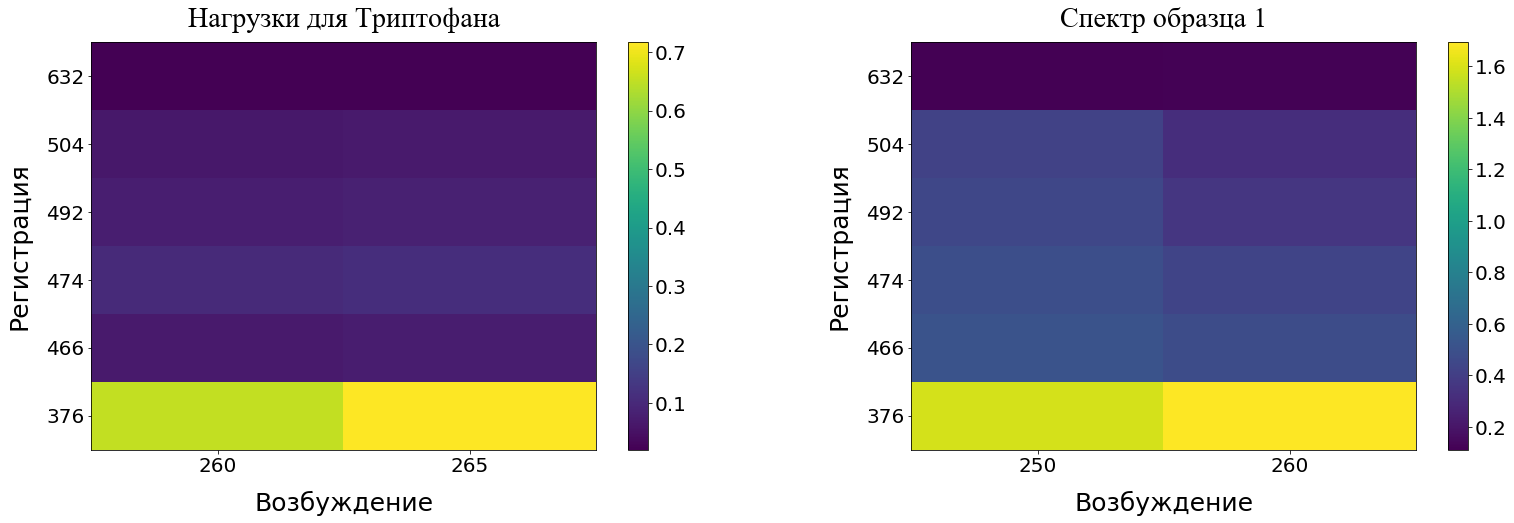

In [158]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(26, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(np.kron(model.w_k[0,:],model.w_i[0,:]).reshape([6,2]),aspect="auto", origin='lower')
fig_ax_1.set_xticks(range(0,2,1))
fig_ax_1.set_yticks(range(0,6,1))
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Нагрузки для Триптофана",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(emis, fontsize=20)
fig_ax_1.set_xticklabels(exci, fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[1])
plt.imshow(x_new[1,:,:],aspect="auto", origin='lower')
fig_ax_2.set_xticks(range(0,2,1)) # Задаём места, где будет сетка и метки по оси ох
fig_ax_1.set_yticks(range(0,6,1))
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Спектр образца 1",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels([1,376,466,474,492,504,632,2], fontsize=20)
fig_ax_2.set_xticklabels([250, 260, 265,6], fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('Trp_loadings_6_2.png', format='png', dpi=300)
plt.savefig("Trp_loadings_6_2.svg", format="svg")
plt.show();

In [30]:
select=variable_class(number_variable_emission=206, number_variable_excitation=3)
select.finding_variable(b_npls1_full_humic)

In [31]:
b_npls1_full_humic_col=select.transform(b_npls1_full_humic.reshape(1,206,55))

In [32]:
excitation_vale_lendth=select.excitation_vave_lenth(Xdata_numpy['excitation'])

In [33]:
select1=variable_class(number_variable_emission=4, number_variable_excitation=3)
select1.finding_variable(b_npls1_full_humic_col.reshape(206,3))

In [35]:
b_npls1_full_humic_col_row=select1.transform(b_npls1_full_humic_col.reshape(1,206,3))

In [36]:
emission_vale_lendth=select1.emission_vave_lenth(Xdata_numpy['emission'])

In [37]:
excitation_vale_lendth

array([250., 255., 260.])

In [38]:
emission_vale_lendth

array([318., 362., 378., 474.])

In [39]:
b_npls1_full_humic_col_row

array([[[-8.81057658, -8.7175995 , -7.68044725],
        [ 3.22279153,  3.38118076,  3.19677667],
        [-3.54151499, -3.71294009, -3.53612209],
        [ 3.30281856,  3.52102314,  2.78299893]]])

In [ ]:
b_npls1_full_humic

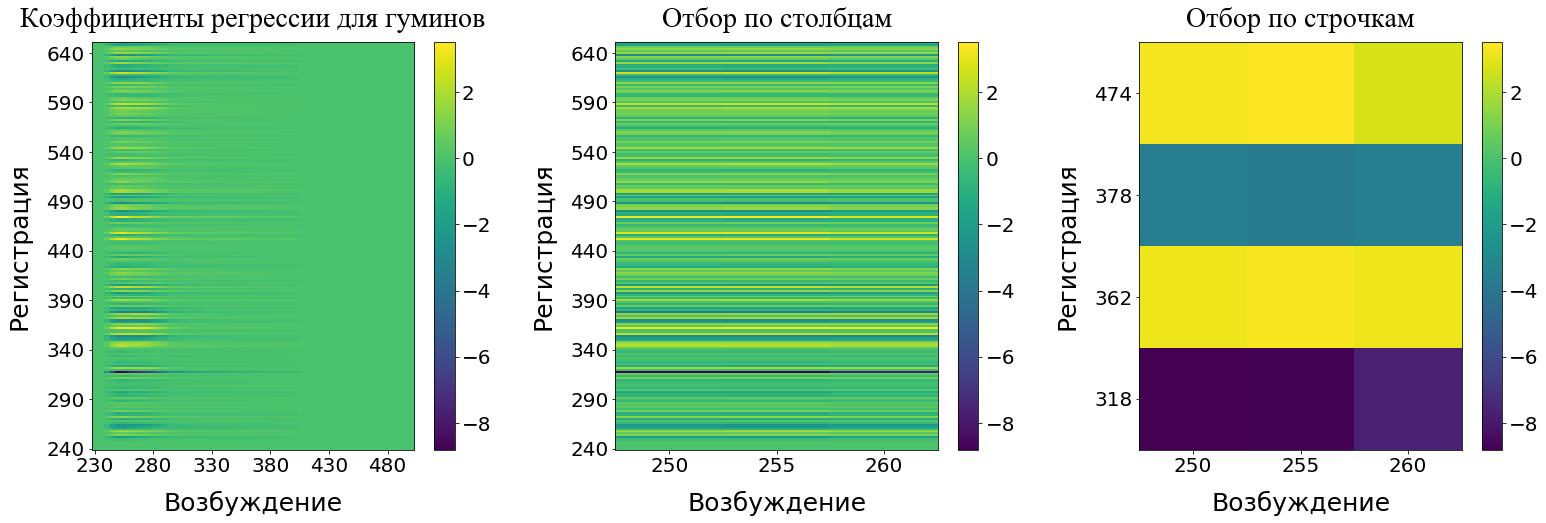

In [51]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(26, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full_humic,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Коэффициенты регрессии для гуминов",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[1])
plt.imshow(b_npls1_full_humic_col.reshape(206,3),aspect="auto", origin='lower')
fig_ax_2.set_xticks(range(0,3,1)) # Задаём места, где будет сетка и метки по оси ох
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Отбор по столбцам",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels([250, 255, 260], fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_3 = fg.add_subplot(gs[2])
plt.imshow(b_npls1_full_humic_col_row.reshape(4,3),aspect="auto", origin='lower')
fig_ax_3.set_xticks(range(0,3,1))
fig_ax_3.set_yticks(range(0,4,1))
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Отбор по строчкам",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_3.set_yticklabels([318, 362, 378, 474], fontsize=20)
fig_ax_3.set_xticklabels([250, 255, 260], fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('Отбор длин волн мой.png', format='png', dpi=300)
plt.savefig("Отбор длин волн мой.svg", format="svg")

plt.show();

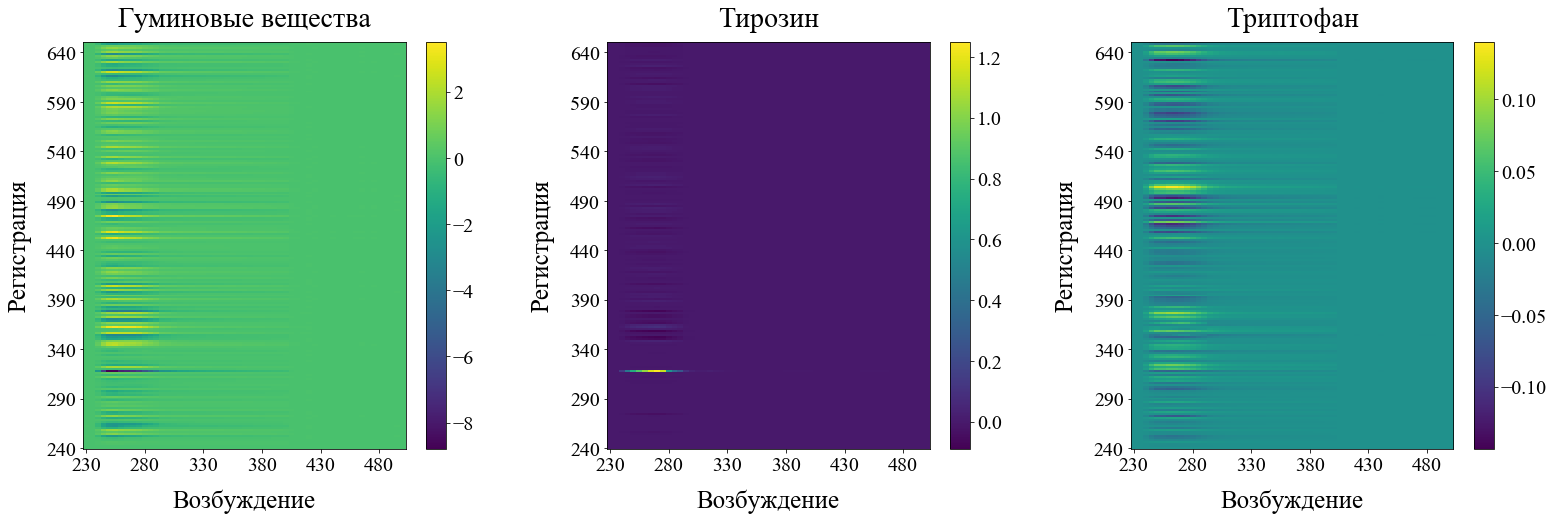

In [95]:
import matplotlib.gridspec as gridspec
fg = plt.figure(figsize=(26, 7.5),constrained_layout=False)
gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fg)
#plt.title("Центрирование спектра образца 5",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=45)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

fig_ax_1 = fg.add_subplot(gs[0])
plt.imshow(b_npls1_full_humic,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Гуминовые вещества",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
#plt.yticks(range(240,690,50),fontsize=20)
fig_ax_1.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_1.set_xticklabels(range(180,520,50), fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_2 = fg.add_subplot(gs[1])
plt.imshow(b_npls1_full_Tyr,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Тирозин",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_2.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_2.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

fig_ax_3 = fg.add_subplot(gs[2])
plt.imshow(b_npls1_full_Trp,aspect="auto", origin='lower')
plt.ylabel("Регистрация" , fontsize=25,labelpad=15)
plt.xlabel("Возбуждение",  fontsize=25,labelpad=15)
plt.title("Триптофан",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
fig_ax_3.set_yticklabels(range(190,690,50), fontsize=20)
fig_ax_3.set_xticklabels(range(180,520,50), fontsize=20)
#plt.yticks(indexi,high,fontsize=20)
#plt.xticks(indexx,lower,fontsize=20)

plt.savefig('Регрессионные коэффициенты.png', format='png', dpi=300)
plt.savefig("Регрессионные коэффициенты.svg", format="svg")

plt.show();

# Строю R2 по новому

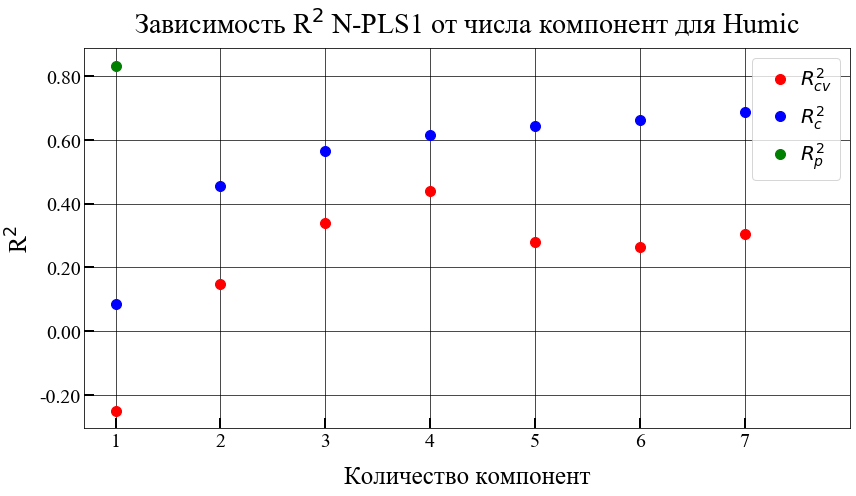

In [22]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(r2_cv,".",color="red",ms=20,label='$R_{cv}^{2}$')
axs.plot(r2_c,".",color="blue",ms=20,label='$R_c^{2}$')
axs.plot(r2_p,".",color="green",ms=20,label='$R_p^{2}$')

axs.set_xticks(range(0,7,1)) # Задаём места, где будет сетка и метки по оси ох
#axs.set_yticks(np.linspace(0.72, 0.77, num = 6))

axs.set_ylabel('R$^{2}$',  fontsize=25,labelpad=5)
axs.grid(color="black", drawstyle="default", linewidth=0.7)
axs.set_xlabel("Количество компонент",  fontsize=25,labelpad=15)
axs.set_title("Зависимость R$^{2}$ N-PLS1 от числа компонент для Humic", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
#axs.ticklabel_format()

axs.set_xticklabels(range(1,9,1), fontsize=20)
axs.set_yticklabels(['0.72','-0.20','0.00','0.20','0.40','0.60','0.80','0.75','0.70'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(loc=1,fontsize=20, markerscale=1,handletextpad=0)

axs.set_xlim(xmax=7) # можно определить границы графика которые будут выводиться на экран
fig.tight_layout()
#fig.set_figwidth(12) можно задать размеры самого поля для рисования
#fig.set_figheight(6)

plt.savefig('N-PLS1 Humic without v-s.png', format='png', dpi=300)
plt.savefig("N-PLS1 Humic without v-s.svg", format="svg")


plt.show();

# Строю введено-найдено по новому

In [24]:
yTest=y_test+result.medium

In [25]:
y_test

array([  5.45213345,  -3.08549775, -18.58347562,  14.64600637,
         7.58267641])

In [26]:
yTest

array([45.44679116, 36.90915996, 21.41118209, 54.64066407, 47.57733412])

In [27]:
n_predictors=predictors+result.medium

In [28]:
n_predictors

array([47.1857551 , 37.69676265, 30.2328919 , 56.03148358, 42.61826396])

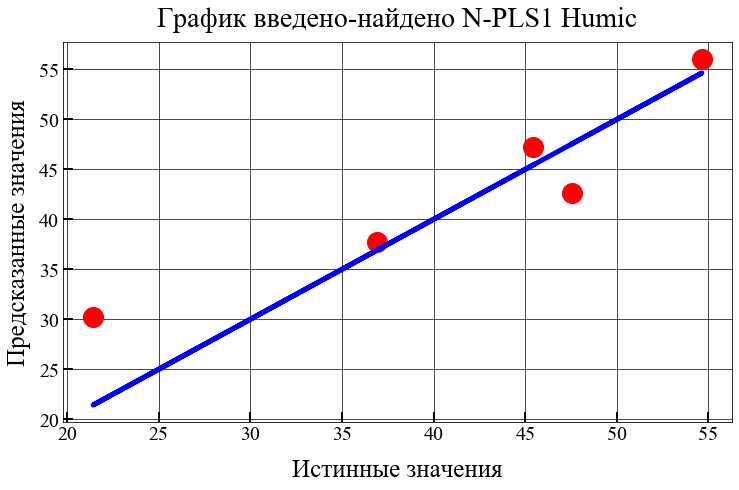

In [31]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(yTest,n_predictors,".",color="red",ms=40)
axs.plot(yTest,yTest,color="blue",lw=5)
#axs.set_yticks(np.linspace(1.0, 4.5, num = 8))
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График введено-найдено N-PLS1 Humic", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(['15','20','25','30','35','40','45','50','55','60'], fontsize=20)
axs.set_yticklabels(['15','20','25','30','35','40','45','50','55','60'], fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График введено-найдено N-PLS1 Trp Humic.png', format='png', dpi=300)
plt.savefig("График введено-найдено N-PLS1 Trp Humic.svg", format="svg")
plt.show();

# Сохраним абсолютно всё в пикль, потому что считать заново - это очень долго.

In [66]:
pkl.dump(
	{'r2_cv': r2_cv, 'r2_c': r2_c, 'r2_p': r2_p, 'predict':predictors,'y_test':y_test,
     'parametrs':gridCought.best_params_, 'True_predictors':n_predictors, 'True_y':yTest,
     'X_test':X_test,'X_train':X_train,'y_train':y_train, 'b_npls1_without_w-s':b_npls1_full,
     'w_i_best_estimator':gridCought.best_estimator_.w_i,'w_k_best_estimator':gridCought.best_estimator_.w_k},
	open('C:/Users/admin/Desktop/PLS2021/N-PLS/Humic_N-PLS1_final.pkl.gz', 'wb')
)